# Part 2: Genres and communities and plotting
The questions below are based on Lecture 7, part 2.

## Write about genres and modularity

Modularity is a measure that evaluates how well a network partitioning devides the network into communities. It does this by comparing the density of edges inside the communities vs the density between the communites. 
A high moduality means that the nodes of the communities are highly connected and there are few connections between the communities. A modularity of 1 means that there are only edges inside communities and no edges between communities, i.e. communities are perfectly seperated. A low modularity around 0 means that there is no more community structure that there would be in a random network. Modularity can also be negative, and this means that the community structure is weaker than if the network had been random.

When we group/partition nodes based on genre, the modularity measure tells us something about if the bands that play the same genre music often will link to other bands with the same genre, or do they often link across genres. A high modularity would suggest that for instance pop-rock bands link primarily to other pop-rock bands.

## Detect the communities, discuss the value of modularity in comparison to the genres

To detect communities we firstly create a network of all the bands where an attribute on each node is all the genres listed in their wiki-infobox. To be able to compare and group the bands later we will add the genres in lowercase and normalize the genre names, e.g. "R&B"->"rhythm and blues" etc. We have also chosen to remove the qualifiers of genres stating if the genre is "(early)" or "(later)" to make fewer categories and see stronger patterns.

In the following code we have created the functions to detect the genres inside the infoboxes of the plain wiki-text of the bands, and a function to clean the found genres.

In [26]:
import re
import html
import os
from collections import Counter, defaultdict
import math
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
import random
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np

def extract_genres_from_wikitext(wikitext_content):
    """
    Extract a cleaned, normalized list of genres from Wikipedia-like wikitext.
    - Removes refs, citation templates, wrapper templates, HTML, and wiki links.
    - Strips all parenthetical qualifiers (e.g., '(early)', '(late)') and broken tails.
    - Lowercases all genres.
    - Normalizes common variants (rock & roll, r&b, hip-hop, post punk, synth pop, etc.).
    - Drops obvious template/config noise.
    - Deduplicates while preserving order.
    """
    # Isolate the 'genre =' field in the infobox
    m = re.search(
        r'\|\s*genre\s*=\s*(.*?)(?=\n\s*\||\n}})',
        wikitext_content,
        flags=re.DOTALL | re.IGNORECASE
    )
    if not m:
        return []
    g = m.group(1)

    # Decode HTML entities (&lt;ref&gt; -> <ref>, &amp; -> &, etc.)
    g = html.unescape(g)

    # Remove HTML comments
    g = re.sub(r'<!--.*?-->', '', g, flags=re.DOTALL)

    # Remove references: self-closing BEFORE paired to avoid cross-line capture
    g = re.sub(r'<ref[^>]*/>', '', g, flags=re.DOTALL | re.IGNORECASE)                      # <ref .../>
    g = re.sub(r'<ref(?:(?!/>)[^>])*?>.*?</ref>', '', g, flags=re.DOTALL | re.IGNORECASE)   # <ref ...>...</ref>

    # Remove citation/footnote templates entirely
    g = re.sub(r'\{\{\s*cite[^{}]*\}\}', '', g, flags=re.IGNORECASE)                        # {{cite web|...}}
    g = re.sub(r'\{\{\s*harv-?nb?[^{}]*\}\}', '', g, flags=re.IGNORECASE)                   # {{harvnb}}, {{harv-nb}}
    g = re.sub(r'\{\{\s*(sfn|sfnb|efn|refn)[^{}]*\}\}', '', g, flags=re.IGNORECASE)         # {{sfn}}, {{refn}}, etc.
    g = re.sub(r'\{\{\s*(citation needed|cn)[^{}]*\}\}', '', g, flags=re.IGNORECASE)        # {{citation needed}}, {{cn}}

    # Drop wrapper templates but keep their inner content
    g = re.sub(r'\{\{\s*(flatlist|hlist|nowrap|plainlist|ubl|unbulleted list)\s*\|?', '',
               g, flags=re.IGNORECASE)

    # Remove remaining braces and HTML tags like <small>, <i>, etc.
    g = g.replace('{{', '').replace('}}', '')
    g = re.sub(r'<[^>]+>', '', g)

    # Replace wiki links [[A|B]] -> B; [[A]] -> A
    g = re.sub(r'\[\[(?:[^|\]]+\|)?([^\]]+)\]\]', r'\1', g)

    # Normalize whitespace (incl. NBSP) and bullets
    g = g.replace('\xa0', ' ')
    g = g.replace('*', ' ')

    # Split on common delimiters
    parts = re.split(r'[\n,;•·]+|\s*\|\s*', g)

    # --- Normalization helpers ---

    # Canonical mapping for near-duplicates and synonyms (all keys/values lowercase)
    CANON_MAP = {
        # rock and roll family
        "rock & roll": "rock and roll",
        "rock and roll": "rock and roll",
        "rock 'n' roll": "rock and roll",
        "rock ’n’ roll": "rock and roll",
        "rock `n` roll": "rock and roll",

        # r&b / rhythm & blues
        "r&b": "rhythm and blues",
        "r & b": "rhythm and blues",
        "rhythm & blues": "rhythm and blues",

        # hip hop
        "hip-hop": "hip hop",
        "hip–hop": "hip hop",

        # hyphen/space variants
        "post punk": "post-punk",
        "synth pop": "synth-pop",
        "dance rock": "dance-rock",
        "blue eyed soul": "blue-eyed soul",

        # AOR
        "aor": "album-oriented rock",
    }

    # Regexes for pattern families
    ROCKNROLL_RX = re.compile(r"rock\s*(?:&|and|['`´’]\s*n['`´’])\s*roll")
    HIPHOP_RX    = re.compile(r"hip\s*[-–]?\s*hop")
    RAND_B_RX    = re.compile(r"(?:^|\b)r\s*&\s*b(?:\b|$)|rhythm\s*&\s*blues")

    # Token acceptability: letters (incl. accents), numbers, space, hyphen, apostrophes/quotes, ampersand, dots
    ALLOWED_RX   = re.compile(r"^[0-9A-Za-zÀ-ÖØ-öø-ÿ\s\-\&'`´’\.]+$")

    # Substrings indicating template/config noise to drop
    DROP_SUBSTRS = [
        'citation', 'cite', 'access-date', 'archive-url', 'archive-date',
        'publisher=', 'website=', 'title=', 'url=', 'first=', 'last=',
        'class=', 'nowrap', 'italic', 'lang', 'script=', 'format='
    ]

    def normalize_label(t: str) -> str:
        # Trim punctuation
        t = t.strip()
        t = re.sub(r'^[\W_]+|[\W_]+$', '', t)
        if not t:
            return ''

        # Drop obvious noise
        lo = t.lower()
        if any(s in lo for s in DROP_SUBSTRS):
            return ''

        # Remove any parenthetical parts, even if multiple (e.g., "(early)", "(later)")
        t = re.sub(r'\s*\([^)]*\)', '', t).strip()
        # If an unmatched '(' tail remains, drop that too (e.g., "funk metal (early")
        t = re.sub(r'\s*\([^)]*$', '', t).strip()

        # Lowercase
        t = t.lower()

        # Normalize rock and roll forms
        if ROCKNROLL_RX.search(t):
            t = ROCKNROLL_RX.sub('rock and roll', t)

        # Normalize hip hop forms
        if HIPHOP_RX.search(t):
            t = HIPHOP_RX.sub('hip hop', t)

        # Normalize r&b / rhythm & blues
        if RAND_B_RX.search(t):
            t = 'rhythm and blues'

        # Apply canonical map (covers aor, synth-pop, post-punk, blue-eyed soul, dance-rock, etc.)
        t = CANON_MAP.get(t, t)

        # Reject invalid tokens (after normalization)
        if not ALLOWED_RX.match(t):
            return ''

        # Collapse repeated spaces and strip stray punctuation
        t = re.sub(r'\s{2,}', ' ', t).strip('. ').strip()

        return t

    cleaned = [normalize_label(p) for p in parts]
    cleaned = [c for c in cleaned if c]

    # Deduplicate while preserving order (already lowercase)
    out, seen = [], set()
    for x in cleaned:
        if x not in seen:
            seen.add(x)
            out.append(x)
    return out

In the following we loop through all wiki-texts of bands in a directory and make a dictionary of the bands and their genres.

In [4]:
# Directory where all band data files are located
data_directory = "../Noa/Bands"
band_genres = {}

# Iterate over all files in the specified directory
for filename in os.listdir(data_directory):
    file_path = os.path.join(data_directory, filename)
    band_name = os.path.splitext(filename)[0] # Get band name from filename

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()

            wikitext_content = content

            genres = extract_genres_from_wikitext(wikitext_content)
            band_genres[band_name] = genres
    except Exception as e:
        print(f"Error processing file {filename}: {e}")

# order the band list alphabetically
band_genres = dict(sorted(band_genres.items()))

The top 15 genres are listed below in a histogram

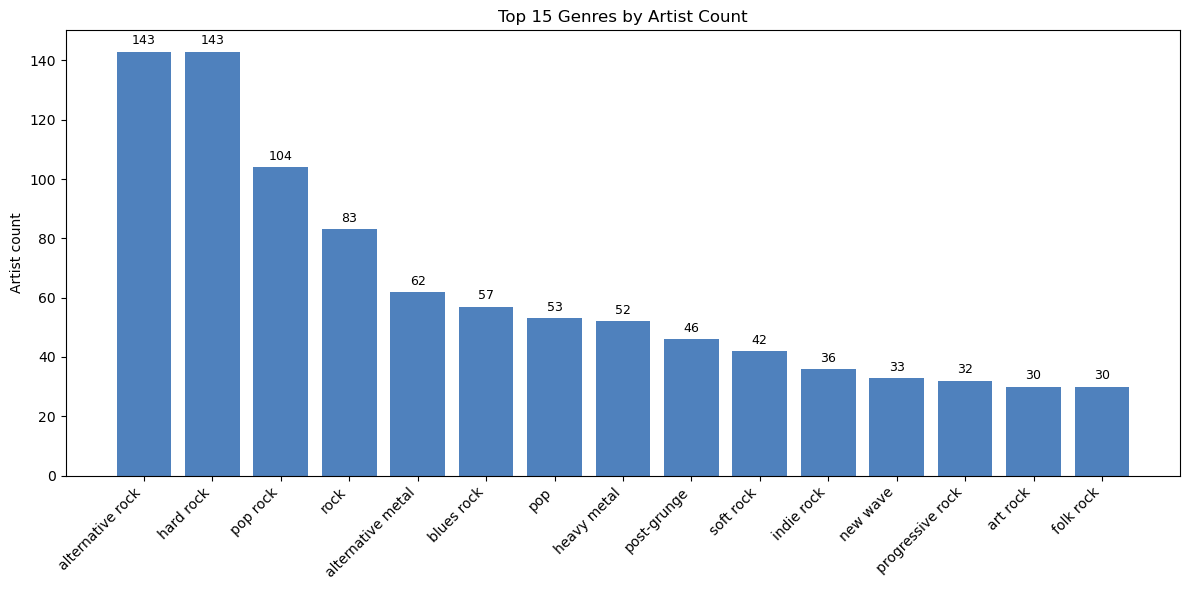

In [7]:
# Artists with at least one genre
artists_with_genres = {artist: genres for artist, genres in band_genres.items() if genres}

# Top-15 genres histogram (by artist counts)

# Count per genre (ensures an artist counted only once per genre even if duplicates slipped in)
genre_to_artists = defaultdict(set)
for artist, genres in artists_with_genres.items():
    for g in set(genres):  # set() to be safe against accidental duplicates
        genre_to_artists[g].add(artist)

genre_counts = Counter({g: len(artist_set) for g, artist_set in genre_to_artists.items()})

top_n = 15
top15 = genre_counts.most_common(top_n)

# Plot
if top15:
    genres_plot, counts_plot = zip(*top15)
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(genres_plot)), counts_plot, color="#4F81BD")
    plt.xticks(range(len(genres_plot)), genres_plot, rotation=45, ha='right')
    plt.ylabel("Artist count")
    plt.title(f"Top {top_n} Genres by Artist Count")
    # Add value labels on bars
    for bar, val in zip(bars, counts_plot):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts_plot)*0.01,
                 str(val), ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No genres to plot for histogram (top15 is empty).")

Above we have on the y-axis the frequency/the number of bands that have the genre on the x-axis as one of their listed genres in their wiki-infobox. It is worth to note that a lot of these genres are rock sub-genres, but we have chosen not to join these genres into one and keep them seperated. 

We would now like to explore how communitylike the communities are, if we consider the genres to be community labels. We use the modularity measure to do this. We firstly create the undirected links between the bands and we only keep the bands that actually have infoboxes and have a genre list in their wiki-text. The links between bands are added using the graph constructed for Assignment 1.

Removed 15 nodes with no links. The graph now has 457 nodes.


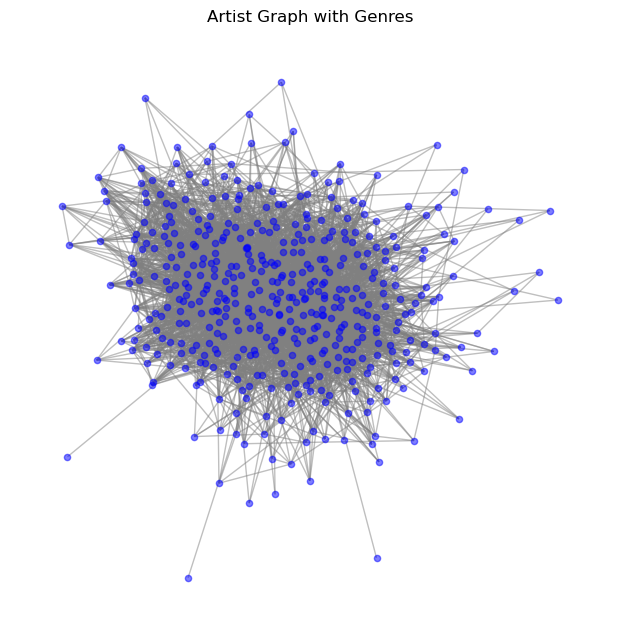

The final graph has 457 nodes and 5569 edges.


In [ ]:
# Create an empty graph
G_artists = nx.Graph()

# Add nodes to the graph from the artists_with_genres
# The keys of the dictionary are the artist names (nodes)
# The values are the lists of genres (attributes)
for artist, genres in artists_with_genres.items():
    G_artists.add_node(artist, genres=genres)

# Load the original links graph from Assignment 1
G_links = nx.read_graphml(r"/Users/noa/Desktop/02805 - Social Graphs/SocialGraphs/Noa/Bands_graph.graphml")

# Adding edges to G_artists based on G_links
G = G_artists.copy()

for u, v in G_links.edges():
    if G.has_node(u) and G.has_node(v):
        G.add_edge(u, v)

# NOTE: G is now our final graph with genres as node attributes and the links are the original links from Assignment 1 and all nodes are removed that has no info-box

# Remove nodes with no links
nodes_to_remove = [node for node in G.nodes() if G.degree(node) == 0]
G.remove_nodes_from(nodes_to_remove)
print(f"Removed {len(nodes_to_remove)} nodes with no links. The graph now has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, seed=42)  # positions for all nodes
nx.draw(G, pos, node_size=20, node_color='blue', edge_color='gray', alpha=0.5)
plt.title("Artist Graph with Genres")
plt.show()


Above we have chosen to remove the bands/nodes that doesn't have any links, as these could contribute to the modularity measure being misleading. This is because isolated nodes have no edges, so they do not contribute to community structure. These nodes will likely be assigned to their own “community” by most algorithms. When we later try to create louvain communities this will most likely create many tiny communities, lowering modularity and making the network look fragmented.

To create the partitioning we choose the first genre in the list as the label for the node/band. This makes each community be the group of nodes that share the same first genre in their list of genres. We then calculate the modularity according to Eq. 9.12 in the book.

In [16]:
# Each node is assigned to the community of its first listed genre
communities_by_genre = defaultdict(list)
for node, data in G.nodes(data=True):
    genres = data.get('genres')
    if genres:
        first_genre = genres[0]
        communities_by_genre[first_genre].append(node)

# a list of sets (the communities).
partition = [set(nodes) for nodes in communities_by_genre.values()]

def modularity(G, partition):
    """
    Compute modularity using Eq. 9.12:
    """
    L = G.number_of_edges()  # total edges
    degrees = dict(G.degree())

    M = 0.0
    for community in partition:
        # Internal edges in community
        L_c = G.subgraph(community).number_of_edges()
        # Sum of degrees in community
        k_c = sum(degrees[node] for node in community)
        M += (L_c / L) - (k_c / (2 * L)) ** 2

    return M

# Calculate and report the modularity 
mod = modularity(G, partition)
print(f"\nCreated a partition with {len(partition)} communities based on the first genre.")
print(f"Modularity: {mod:.4f}")


Created a partition with 77 communities based on the first genre.
Modularity: 0.0944


From the modularity we can conslude that the genres are not a good community. 
A score near or below zero indicates the partitioning is no better than random. In our case (with a modularity of 0.0944) this means that there is no community based on the first genre in the list compared to how the bands link to each other on their wiki-pages. 

TODO
Instead of choosing the first genre as the base for the partitioning, if we instead choose a random genre it might improve the community structure.

In [ ]:
random.seed(42)

communities_by_genre_rand = defaultdict(set)

for node, data in G.nodes(data=True):
    genres = data.get('genres') or []
    if not genres:
        continue
    chosen = random.choice(genres)  # uniform random choice among available genres
    communities_by_genre_rand[chosen].add(node)

# Remove empty sets and return as list of sets
partition_rand = [nodes for nodes in communities_by_genre_rand.values() if nodes]

M_rand = modularity(G, partition_rand)
print(f"Random-genre partition modularity: {M_rand:.4f}")

Random-genre partition modularity (single draw): 0.0365


TODO skriv noget om det her

**Discuss your findings - and decide how you want to settle on a single genre for each band.**

The modality is now lower

**CHAT SVAR**
Genres as communities are weak overall
Both modularity values are low (well below 0.3, which is often considered strong community structure). This means the network’s connectivity does not strongly align with genre labels.


First genre performs better than random
The modularity for the first-genre partition is more than double the random assignment (0.0944 vs. 0.0365). This suggests that the first genre in the list is not arbitrary—it captures some real structure, but still weak.


Interpretation

Genres are not perfect predictors of network connectivity.
Multi-genre nodes introduce ambiguity: picking randomly dilutes structure further.
The improvement from random to first genre implies some consistency in how genres are ordered (likely the primary genre is listed first).

## Plot the communities and comment on your results

We will now use the Louvain-algorithm to find communities for the network.

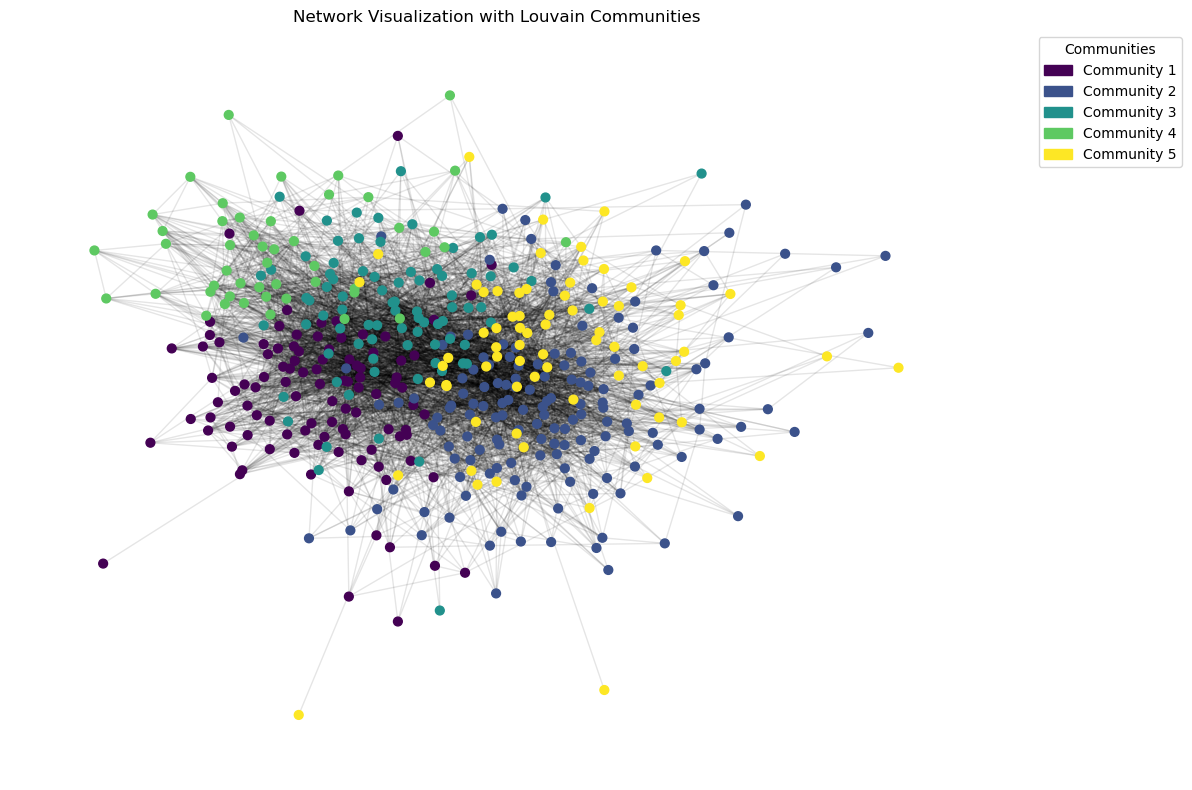


Louvain method found 5 communities with a modularity of 0.3390.


In [25]:
# using networkx louvain_communities to find communities
louvain_communities = list(nx.community.louvain_communities(G, seed=11))
louvain_modularity = nx.community.modularity(G, louvain_communities)

# visualize the network using the Force Atlas algorithm with communities colored differently
# using louvain_communities
partition = {}
for i, community in enumerate(louvain_communities):
    for node in community:
        partition[node] = i


# Set the size of the plot
plt.figure(figsize=(12, 8))
# Compute the layout using spring layout (Force Atlas-like)
pos = nx.spring_layout(G, seed=42)
# Draw nodes with colors based on their community
cmap = plt.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.1)
# We will create custom legend handles because networkx doesn't do it automatically
legend_handles = []
for i in range(len(louvain_communities)):
    legend_handles.append(Patch(color=cmap(i), label=f'Community {i+1}'))

plt.legend(handles=legend_handles, title="Communities", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Network Visualization with Louvain Communities")
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\nLouvain method found {len(louvain_communities)} communities with a modularity of {louvain_modularity:.4f}.")

TODO
We observe that the nodes (bands) are largely grouped by color, indicating that the Louvain communities are visually distinct in the network. For example, the purple community (Community 1) is concentrated in the southwest region of the graph, while the green community (Community 4) is in the northwest region.

When we rerun the Louvain algorithm with a different random seed, the number of detected communities can change, as the Louvain algorithm is a heuritic algorithm. For instance, if the method produces only 4 communities instead of more, this could be because the yellow and dark blue communities (Communities 5 and 2) are merged. This makes sense visually, as these two clusters overlap significantly. Similarly, the turquoise community (Community 3), which sits near the center of the network and overlaps with multiple other communities, might be split and redistributed across neighboring clusters in such cases.

TODO The partitioning is now much more community-like now, as the moduality is higher 0.3390. This suggest a moderate community structure and that that there is a community structure in the partitioning compared to a random linking or the before seen genre based partitioning.

We will now create and visualize the confusion matrix comparing the Louvain communities with music genres

## Calculate the matrix $D$ and discuss your findings

We will now compare the communities found by the Louvain algorithm with the music genres by creating a matrix D with dimension (GxC), where G is the 5 most common genres and C is the 5 most common communities. We set entry D(i,j) to be the number of nodes that genre i has in common with community j.

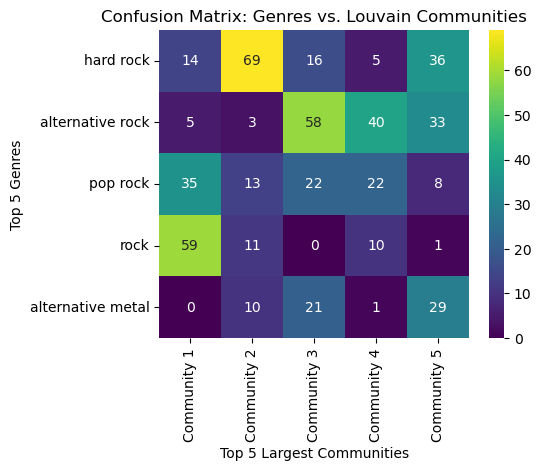

In [27]:
# Identify the 5 most common genres - Using all genres associated with each node
all_genres_list = []
for node, data in G.nodes(data=True):
    if 'genres' in data:
        all_genres_list.extend(data['genres'])

genre_counts = Counter(all_genres_list)
top_5_genres = [genre for genre, count in genre_counts.most_common(5)]
top_5_genres_set = set(top_5_genres)


# Identify the 5 largest communities
louvain_communities.sort(key=len, reverse=True)
top_5_communities = louvain_communities[:5]

# Create a set of all nodes that are in one of the top 5 communities
nodes_in_top_communities = set()
for community in top_5_communities:
    nodes_in_top_communities.update(community)


genre_to_idx = {genre: i for i, genre in enumerate(top_5_genres)}
# Map each node to its community index (1-5)
node_to_community_idx = {}
for i, community in enumerate(top_5_communities):
    for node in community:
        node_to_community_idx[node] = i


# Confusion matrix
confusion_matrix = np.zeros((5, 5), dtype=int)

# Iterate through all nodes in the graph that are in the top communities
for node in nodes_in_top_communities:
    # Check if the node has genre data
    if 'genres' in G.nodes[node]:
        node_genres = G.nodes[node]['genres']
        
        # Find which of the top 5 genres this node has
        relevant_genres = top_5_genres_set.intersection(node_genres)
        
        # If the node has at least one of the top 5 genre
        if relevant_genres:
            community_idx = node_to_community_idx[node]
            
            for genre in relevant_genres:
                genre_idx = genre_to_idx[genre]
                confusion_matrix[genre_idx, community_idx] += 1


# Visualize
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='viridis',
            xticklabels=[f'Community {i+1}' for i in range(5)],
            yticklabels=top_5_genres)
plt.title('Confusion Matrix: Genres vs. Louvain Communities')
plt.ylabel(f'Top {5} Genres')
plt.xlabel(f'Top {5} Largest Communities')
plt.show()

The Louvain algorithm produced six communities, which means we could not directly compare the top seven genres and communities as initially planned. Instead, we focused on the top five communities and the top five genres.

The rows of the matrix are the top‑5 genres in the entire network and the columns are the top-5 largest Louvain communities (out of the 6 we found). Each cell (i,j) in the confusion matrix is the number of nodes in community j that have genre i, where each band can have multiple genres. A lighter yellow color represents more bands falling into this cell and a darker the opposite. Therefore a yellow color means that many bands in Louvain community j have genre i among their listed genres.

For the genres and communities to be well alligned, every column needs to have only one standout high-value cell. This would mean that Louvain communities aligns well with the genres of the bands/nodes. If columns show several similar counts, the community is mixed across genres. We can see that community 2 and the 'hard rock' genre aligns; $\frac{69}{69+3+13+11+10}\sim65$% of community 2 consists of bands that have hard rock as one of their genres. On the contrary community 5 has a wider spread genre mix, where both 'hard rock, 'alternative rock' and 'alternative metal' are highly represented.

There is a large value in a row 'rock', community 1, and low numbers in the rest of the columns representing the communities. This means that almost all band that have rock genre fall into this community. If the row’s counts are spread across many columns, that genre is diffuse across multiple communities which is the case for 'pop-rock' for instance.

Because we counted every genre per band, a band may appear in multiple rows. As a result, column totals can exceed the actual number of bands, making interpretation more challenging.

A possible improvement would have been to create an umbrella category, “Rock genres”, combining all rock subgenres. This would collapse the top four genres into one and potentially change the conclusions. For this analysis, we kept genres separate.